# Google word vectors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
import gensim
import re

In [4]:
import sys
sys.path.append('../scripts')
import classifier_helpers as ch

## Helper function

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                            X, 
                                                            y, 
                                                            cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Build the dataset

In [7]:
categories = ['rec.motorcycles', 'rec.autos']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

In [8]:
wv = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz',
                                                    binary=True, limit=100000)

In [9]:
wv.doesnt_match(['wheel', 'car', 'wave'])

'wave'

## Reduce to 2 dimensions and plot

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(n_components=2)

In [12]:
wv.vectors.shape

(100000, 300)

In [13]:
twod = pca.fit_transform(wv.vectors)

In [14]:
twod = pd.DataFrame(data=twod, index=wv.vocab)
twod.head(2)

,0,1
</s>,-0.593269,0.232534
in,-0.649492,0.302296


In [15]:
car_words = ['motor', 'engine', 'wheel', 'tire', 'windshield', 'glass',
             'gasoline', 'fuel', 'speed', 'accelerate', 'throttle',
             'pad', 'wave']

In [16]:
sns.set()

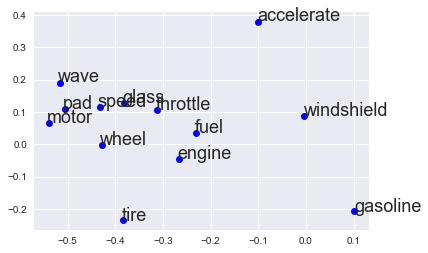

In [17]:
for word in car_words:
    x = twod.loc[word][0]
    y = twod.loc[word][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1+0.01), y*(1+0.01), word, fontsize=18)
plt.savefig('../docs/2d_custom_word_embeddings.png')
plt.show() 

## Clean up punctuation

In [18]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

In [19]:
emails = []
for email in newsgroups_train.data:
    words = word_tokenize(email)
    email_words = []
    for word in words:
        regex_match = re.match(r"\b[a-zA-Z]+\b", word)
        if (regex_match is not None) & (len(word) > 1) & (word not in stopwords):
            email_words.append(wnl.lemmatize(word.lower()))
    emails.append(email_words)

In [20]:
emails[0]

['stuff', 'deleted']

## SVM model 1D vectors

In [21]:
w2v = dict(zip(wv.index2word, wv.vectors))
vectors = []
for email in newsgroups_train.data:
    email_vector = ch.average_vectors(email, w2v, vec_length=300)
    vectors.append(email_vector)

In [22]:
len(vectors)

1192

In [23]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

In [24]:
clf = SVC()

In [43]:
reg_params = np.logspace(0, 8, num=5)
train_scores, valid_scores = validation_curve(clf, vectors, newsgroups_train.target,
                                              "C", reg_params, cv=4, n_jobs=2,
                                              scoring="accuracy")

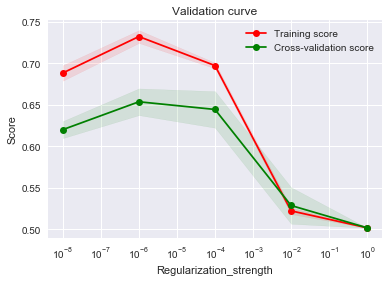

In [44]:
sns.set()
test_scores = valid_scores
train_sizes = 1/reg_params
plt.figure()
plt.title('Validation curve')
plt.semilogx()
plt.xlabel('Regularization_strength')
plt.ylabel('Score')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.savefig('../docs/small_data_regularization_curve.png')
plt.show()

In [27]:
lc_clf = SVC(C=1e6)

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

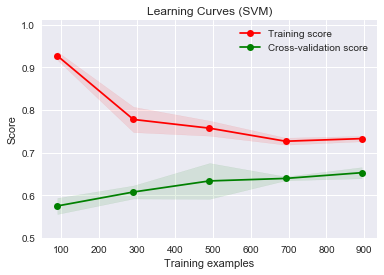

In [46]:
title = "Learning Curves (SVM)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
X, y = vectors, newsgroups_train.target
cv = StratifiedKFold(n_splits=4, random_state=0)
plot_learning_curve(lc_clf, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)
plt.grid()
plt.savefig('../docs/svm_vectors_learning_curve.png')
plt.show()

## 2D representation

Find the longest vector

In [30]:
word_counts = np.array([len(x) for x in emails])

In [31]:
np.argmax(word_counts)

203

(array([163., 171., 184., 130.,  99.,  78.,  67.,  51.,  50.,  34.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

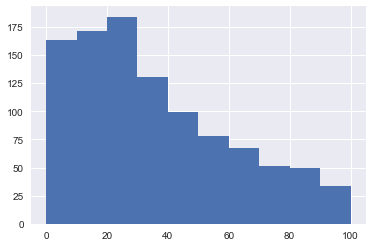

In [32]:
plt.hist(word_counts, range=(0,100))

In [33]:
print(newsgroups_train.data[203])

This is a periodic posting intended to answer the Frequently Asked
Question: What is the DoD? It is posted the first of each month, with
an expiration time of over a month. Thus, unless your site's news
software is ill-mannered, this posting should always be available.
This WitDoDFAQ is crossposted to all four rec.motorcycles groups in an
attempt to catch most new users, and followups are directed to
rec.motorcycles.

Last changed 9-Feb-93 to add a message from the KotL, and a bit of
Halon.

			VERSION 1.1

This collection was originally assembled by Lissa Shoun, from the
original postings. With Lissa's permission, I have usurped the title of
KotWitDoDFAQ. Any corrections, additions, bribes, etc. should be aimed at
blgardne@javelin.sim.es.com.

------------------------------------------------------------------------

Contents:
How do I get a DoD number?	by Blaine Gardner	DoD #46
DoD "Road Rider" article	by Bruce Tanner		DoD #161
What is the DoD?		by John Sloan		DoD #11
The DoD Logo			b

In [34]:
len(newsgroups_train.data[0].split())

2

In [35]:
newsgroups_train.data[0].split()

['Stuff', 'deleted...']

In [36]:
for x in newsgroups_train.data:
    words = 

SyntaxError: invalid syntax (<ipython-input-36-44b9945d29f7>, line 2)